In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%matplotlib notebook

import scipy
from scipy import stats
import numpy as np
import glob, os
import pandas as pd
from itertools import chain
import subprocess
import time
import matplotlib.pyplot as plt

import import phimage as ph

from jupyterthemes import jtplot

jtplot.reset()

porous_dir = '/home/fdutka/porous'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parametry układu eksperymentalnego
$W = 33 \, \rm{mm}$, $L = 38 \, \rm{mm}$, $H = 0.5 \, \rm{mm}$, $D = 10^{-5} \, \rm{cm^2/s}$, $k = 4.67 \cdot 10^{-4} \, \rm{cm/s}$

In [2]:
def PeDa(Q,W,h0):
    """
    returns Peclet and Damkohler numbers
    Q in ml/h, W in mm, h0 in mm
    """
    Q = Q*1e3/3600 # transforms into mm^3/s
    D = 1e-3 # [mm^2/s]
    k = 4.67e-3 # [mm/s]

    Pe = Q/(W*D)
    Da = k*h0*W/Q
    return Pe, Da

def U0(Q,W,h0, hmax):
    """
    returns velocity of flat front in experiment [mm/h]
    Q in ml/h, W in mm, h0 in mm
    """
    phi = 0.55
    csat = 15 # [mol/m^3]
    csol = 2.308/172.173*1e6 # [mol/m^3]

    Q = Q*1e3 # transforms into mm^3/h
    
    U = Q*csat/(W*(hmax-h0)*(1-phi)*csol)
    return U 

In [4]:
U0(1,33,0.07, 0.57)

0.15070374455123162

In [362]:
def nxny(dirin):
    filename = os.path.join(porous_dir, dir1, 'init','phi.dat.00')
    with open(filename,'r') as f:
        l1 = f.readline()
    nx,ny = np.array(l1.split()[:2]).astype(int)
    return nx, ny
    

In [16]:
dirname = "/home/fdutka/Dropbox/ProjektyNaukowe/BTime/simulations/porous/btime3"

In [20]:
btime3 = ph.phimage(dirname)


In [21]:
btime3.std1()

0.08327043252483915

In [4]:
# different tape widths
ht  =np.array([100,70,50,30,20,10,0,150,200])
# initial gypsum height
hg = 500

W = 33 # width of the system
sigma = 5 # assumed deviation standard
h0 = ht+10 # mean initial aperture
cv = np.round(sigma/(h0),5) # coefficient of variance: cv = sigma/ho


In [5]:
folder_names = [f"btime{i}" for i in range(1,len(h0)+1)] 

In [6]:
df = pd.DataFrame(np.array([ht,h0,cv]).T, columns = ['ht','h0','cv'], index = folder_names)
dfPeDa = pd.DataFrame(list(df.apply(lambda x: list(PeDa(1,33,x.h0/1000)), axis = 1)), index = folder_names, columns = ['Pe','Da'])
df = pd.concat([df,dfPeDa], axis = 1)


In [7]:
df = df.assign(hmax = lambda row: hg+row.ht)
df = df.assign(hmax_sim = lambda row: row.hmax/row.h0)
df = df.assign(cv_sim = lambda row: row.cv*1.175)

df['W'] = 33
df['dt'] = 0.1

In [8]:
df

,ht,h0,cv,Pe,Da,hmax,hmax_sim,cv_sim,W,dt
btime1,100.0,110.0,0.04545,8.417508,0.061028,600.0,5.454545,0.053404,33,0.1
btime2,70.0,80.0,0.06250,8.417508,0.044384,570.0,7.125000,0.073438,33,0.1
btime3,50.0,60.0,0.08333,8.417508,0.033288,550.0,9.166667,0.097913,33,0.1
btime4,30.0,40.0,0.12500,8.417508,0.022192,530.0,13.250000,0.146875,33,0.1
btime5,20.0,30.0,0.16667,8.417508,0.016644,520.0,17.333333,0.195837,33,0.1
btime6,10.0,20.0,0.25000,8.417508,0.011096,510.0,25.500000,0.293750,33,0.1
btime7,0.0,10.0,0.50000,8.417508,0.005548,500.0,50.000000,0.587500,33,0.1
btime8,150.0,160.0,0.03125,8.417508,0.088767,650.0,4.062500,0.036719,33,0.1
btime9,200.0,210.0,0.02381,8.417508,0.116507,700.0,3.333333,0.027977,33,0.1


In [10]:
417*0.061028*6.77

172.28753651999997

In [8]:
33*0.07*0.0054/(0.1*0.5)/3.54*4*24

6.765559322033899

In [9]:
df['cv_sim2'] = df.apply(lambda row: phimage(row.name).std1(), axis = 1)

df['cv_sim2_perc'] = df.apply(lambda row: row.cv_sim2/row.cv, axis = 1)

df['NX'] = df.apply(lambda row: phimage(row.name).nx, axis = 1)
df['dx'] = df.apply(lambda row: row.W/(row.NX*row.h0*1e-3), axis = 1)

dfsim = pd.DataFrame(list(df.apply(lambda row: list(phimage(row.name).init()[[2,3,5]]), axis = 1)), columns = ['Pe_sim','Da_sim', 'dx_sim'], index = df.index)
df = pd.concat([df,dfsim], axis = 1)

In [49]:
df['btime'] = df.apply(lambda row: phimage(row.name).BTime(), axis = 1)

In [3]:
df = pd.read_csv("btime.csv", index_col = 0)
df

,ht,h0,cv,Pe,Da,hmax,hmax_sim,cv_sim,W,dt,cv_sim2,cv_sim2_perc,NX,dx,Pe_sim,Da_sim,dx_sim,btime,btime_h
btime1,100.0,110.0,0.04545,8.417508,0.061028,600.0,5.454545,0.053404,33,0.1,0.045446,0.999906,256,1.171875,8.418,0.06100,1.172000,417,109.723934
btime2,70.0,80.0,0.06250,8.417508,0.044384,570.0,7.125000,0.073438,33,0.1,0.062453,0.999250,256,1.611328,8.418,0.04440,1.611000,465,88.984747
btime3,50.0,60.0,0.08333,8.417508,0.033288,550.0,9.166667,0.097913,33,0.1,0.083270,0.999285,256,2.148438,8.418,0.03330,2.148000,515,73.914750
btime4,30.0,40.0,0.12500,8.417508,0.022192,530.0,13.250000,0.146875,33,0.1,0.124829,0.998631,256,3.222656,8.418,0.02220,3.223000,616,58.940435
btime5,20.0,30.0,0.16667,8.417508,0.016644,520.0,17.333333,0.195837,33,0.1,0.166166,0.996973,256,4.296875,8.418,0.01660,4.297000,721,51.740325
btime6,10.0,20.0,0.25000,8.417508,0.011096,510.0,25.500000,0.293750,33,0.1,0.248436,0.993745,256,6.445312,8.418,0.01110,6.445000,950,45.449199
btime7,0.0,10.0,0.50000,8.417508,0.005548,500.0,50.000000,0.587500,33,0.1,0.488096,0.976191,256,12.890625,8.418,0.00555,12.890000,1769,42.315596
btime8,150.0,160.0,0.03125,8.417508,0.088767,650.0,4.062500,0.036719,33,0.1,0.031237,0.999600,256,0.805664,8.417,0.08880,0.805664,373,142.758326
btime9,200.0,210.0,0.02381,8.417508,0.116507,700.0,3.333333,0.027977,33,0.1,0.023834,1.000995,256,0.613839,8.417,0.11700,0.613800,346,173.807305


In [4]:
df_exp = pd.read_csv("BTime_exps_staszeq.csv")

In [5]:
df_exp

,Exp,Aperture,BT [h],CV,computer,date,video,remark
0,1-a,100,99,0.045,Leon,2017-08-17,5L_2017-08-17.avi,ok
1,1-b,100,107,0.045,Leon,2017-08-22,6L_2017-08-22.avi,ok
2,2,70,96,0.063,Hals,2017-05-25,1H_2017-05-25.avi,ok
3,3,50,88,0.083,Leon,2017-06-29,2L_2017-06-29b.avi,ok
4,4,30,89,0.125,Hals,2017-06-29,3H_2017-06-29.avi,ok
5,5-a,0,58,0.500,Leon,2017-08-02,4L_2017-08-02.avi,zapowietrzony
6,6,0,66,0.500,Hals,2016-05-18,22H_2016-05-18.avi,Floriana


In [6]:
df['btime_h'] = df.apply(lambda x: x['dt']*x.btime*x.h0/1000/(x.Da*(x.hmax_sim-1))/U0(1,33,x.h0/1000, x.hmax/1000), axis =1)

<IPython.core.display.Javascript object>


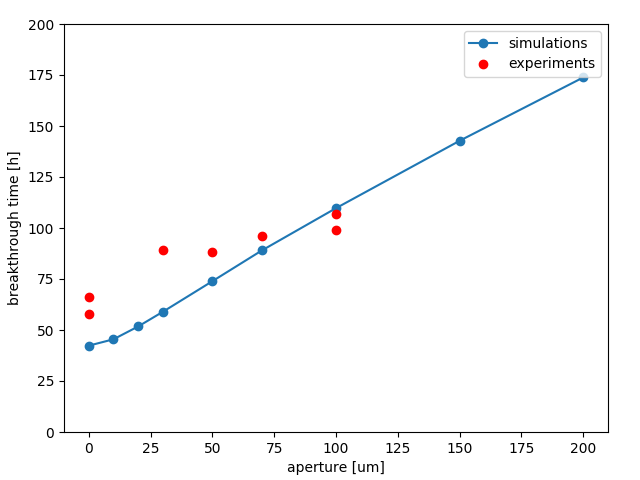

In [7]:
df2 = df.sort_values(by = 'cv')[['cv','btime_h','h0','ht']]

fig2 = plt.figure()
ax = fig2.add_axes([.1,.1,.85,.85])
#ax.plot(df2.cv, df2.btime*df2.Da*df2.dt, '-o')
#ax.plot(df2.cv, df2.btime_h, '-o', label = "simulations")
#ax.plot(df_exp["CV"], df_exp["BT [h]"], 'ro', label = "experiments")

ax.plot(df2.ht, df2.btime_h, '-o', label = "simulations")
ax.plot(df_exp["Aperture"], df_exp["BT [h]"], 'ro', label = "experiments")


#ax.axes.set_xlabel('coefficient of variance')
ax.axes.set_xlabel('aperture [um]')
ax.axes.set_ylabel('breakthrough time [h]')
ax.legend()
ax.set_ylim([0,200])
#fig2.savefig('btime.png', dpi = 300)
plt.ion()
fig2.show()

In [14]:
list(np.log(df2.cv))
#list(np.log(df2.btime*df2.Da*df2.dt))

[-3.7376496184833656,
 -3.4657359027997265,
 -3.0911424583586493,
 -2.772588722239781,
 -2.4849466505880216,
 -2.0794415416798357,
 -1.7917394694280522,
 -1.3862943611198906,
 -0.6931471805599453]

In [42]:
def finish_check(name):
    """
    checks wether actual timestep of simulation exceeds breakthrough time
    """
    b = phimage(name)
    l1 = b.time_steps()
    print(f"{name}: last = {l1[-1]}, btime = {b.BTime()}")

In [31]:
sim = df.iloc[0]
b1 = phimage(sim.name)

In [49]:
# calculation of mean values of height for each timetstep in simulation before breakthrough
lm1 = []

for i in range(len(df)):
    sim = df.iloc[i]
    b1 = phimage(sim.name)
    t = b1.time_steps()
    t = t[t<sim.btime]
    
    m1 = [b1.phi2('phi.'+str(ti).zfill(4)).mean() for ti in t]
    lm1.append([t,m1])

In [90]:
np.round(sim.cv,3)

0.024

/home/fdutka/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


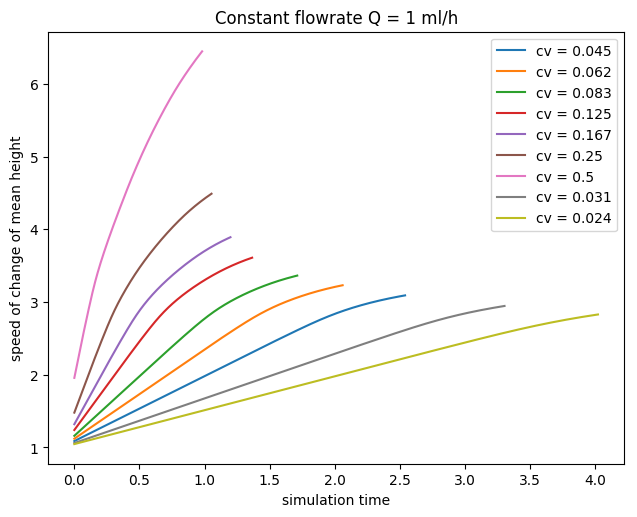

In [96]:
fig = plt.figure()
ax = fig.add_axes([.1,.1,.9, .9])
for i in range(len(df)):
    sim = df.iloc[i]
    m1 = lm1[i]
    ax.plot(m1[0]*sim.Da*sim['dt'], m1[1], '-', label = f"cv = {np.round(sim.cv,3)}")
ax.axes.set_ylabel('speed of change of mean height')
ax.axes.set_xlabel('simulation time')
ax.legend()
ax.axes.set_title('Constant flowrate Q = 1 ml/h')
fig.tight_layout()

fig.savefig('Qspeed_mean_h.png', dpi = 300)
fig

In [71]:
# calculation of speed of change of mean value of h
vh = []
for i in range(len(df)):
    tmax = 100
    ntmax = (lm1[i][0]< tmax).astype(int).sum()
    slope, intercept, r_value, p_value, std_err = stats.linregress(lm1[i][0][:ntmax], lm1[i][1][:ntmax])
    print(f"{df.index[i]}:, {slope} \t {intercept}")
    vh.append(slope)
df['vh'] = vh

btime1:, 0.005463371994194263 	 1.0869542640408323
btime2:, 0.005458266184957456 	 1.1194897359474196
btime3:, 0.005453639017326108 	 1.1592860391294182
btime4:, 0.005435971719653991 	 1.2388247292937842
btime5:, 0.005426506635306718 	 1.3183473902617293
btime6:, 0.005327130127498745 	 1.4774388823013307
btime7:, 0.004917606856789623 	 1.954637171360093
btime8:, 0.005460389976804261 	 1.059789580471004
btime9:, 0.005439924248665832 	 1.0455688344023453


In [72]:
df.to_csv('btime2.csv')

In [97]:
vsim = 0.00544

In [100]:
33**2*df.h0/1e3/df.Da

btime1    1962.883655
btime2    1962.883655
btime3    1962.883655
btime4    1962.883655
btime5    1962.883655
btime6    1962.883655
btime7    1962.883655
btime8    1962.883655
btime9    1962.883655
dtype: float64

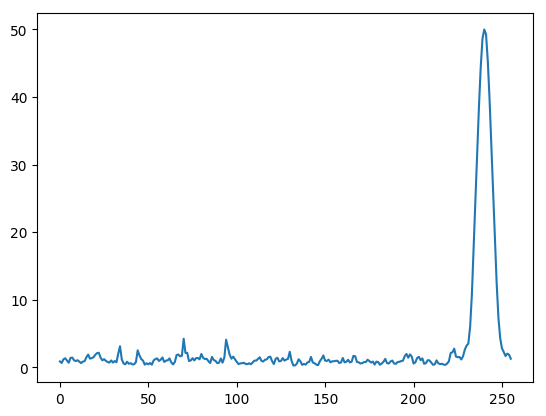

In [101]:
b1 = phimage('btime7')

phi = b1.phi2('phi.1769')

plt.ion()
plt.plot(np.arange(len(phi[-1])), phi[-1])